In [1]:
import tensorflow as tf

In [2]:
import os,glob
import numpy as np
import cv2
import glob
import pickle
import tensorflow as tf
import argparse
import re
import datetime
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,LeakyReLU,Add,Average,Lambda,MaxPool2D,Dropout,UpSampling2D,Concatenate,Multiply,GlobalAveragePooling2D,Dense,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.layers import concatenate,Flatten,ConvLSTM2D,LayerNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
import tensorflow.keras.backend as K
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.feature import hog,local_binary_pattern
from skimage import data, exposure
from tensorflow.keras.layers import Layer 

In [3]:

!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

normal_dir = "./covid-chestxray-dataset/images"
dir1 = os.path.join(normal_dir,"*.png")
dir = os.path.join(normal_dir,"*.jpg")
dir2 = os.path.join(normal_dir,"*.jpeg")
covid_files = glob.glob(dir)
covid_files2 = glob.glob(dir2)
covid_files1 = glob.glob(dir1)
covid_files.extend(covid_files2)
covid_files.extend(covid_files1)
print("Number of covid-19 files")
print(len(covid_files))

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3614, done.
remote: Total 3614 (delta 0), reused 0 (delta 0), pack-reused 3614
Receiving objects: 100% (3614/3614), 632.87 MiB | 39.56 MiB/s, done.
Resolving deltas: 100% (1433/1433), done.
Checking out files: 100% (1173/1173), done.
Number of covid-19 files
924


In [4]:
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"
dir1 = os.path.join(normal_dir,"*.png")
dir2 = os.path.join(normal_dir,"*.jpeg")
dir = os.path.join(normal_dir,"*.jpg")
normal_files = glob.glob(dir)
normal_1 = glob.glob(dir1)
normal_2 = glob.glob(dir2)
normal_files.extend(normal_1)
normal_files.extend(normal_2)
print("Number of normal files")
print(len(normal_files))

normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"
dir1 = os.path.join(normal_dir,"*.png")
dir2 = os.path.join(normal_dir,"*.jpeg")
dir = os.path.join(normal_dir,"*.jpg")
pneumonia_files = glob.glob(dir)
pneumonia_1 = glob.glob(dir1)
pneumonia_2 = glob.glob(dir2)
pneumonia_files.extend(pneumonia_1)
pneumonia_files.extend(pneumonia_2)

train_dic = {}
for f in covid_files[:739]:
  train_dic[f] = [1,0,0]
for f in normal_files[:1072]:
  train_dic[f] = [0,1,0]
for f in pneumonia_files[:3100]:
  train_dic[f] = [0,0,1]
print("Number of Pneumonia files")
print(len(pneumonia_files))

test_dic = {}
for f in covid_files[739:]:
  test_dic[f] = [1,0,0]
for f in normal_files[1072:]:
  test_dic[f] = [0,1,0]
for f in pneumonia_files[3100:]:
  test_dic[f] = [0,0,1]

import random
l = list(train_dic.items())
random.shuffle(l)
l_test = list(test_dic.items())
random.shuffle(l_test)
print(len(l),len(l_test))

train_features = []
covid_dic_list = {}
data = []
data_112 = []
data_56 = []
data_256 = []
labels = []
for i in range(len(l)):
  file_name,label = l[i]
  img = cv2.imread(file_name)
  try:
    img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
    #img2 = cv2.resize(img,(256,256),interpolation = cv2.INTER_CUBIC)
    #img3 = cv2.resize(img,(112,112),interpolation = cv2.INTER_CUBIC)
    #img4 = cv2.resize(img,(56,56),interpolation = cv2.INTER_CUBIC)
    
    img = img.astype('float32')/255.0
    #img2 = img2.astype('float16')/255.0
    #img3 = img3.astype('float32')/255.0
    #img4 = img4.astype('float16')/255.0
    
    #data_56.append(img4)
    #data_112.append(img3)
    #data_256.append(img)2
    data.append(img)
    labels.append(label)

  except:
    print(i,file_name)
    print("Not possible")  
train_data = np.array(data)
print("Shape of training data")
print(train_data.shape)


#train_data_56 = np.array(data_56)
#print(train_data_56.shape)
#train_data_112 = np.array(data_112)
#print(train_data_112.shape)
#train_data_256 = np.array(data_256)
#print(train_data_256.shape)


train_labels = np.array(labels)
print("Shape of training labels")
print(train_labels.shape)    

print('^_^-training data finished-^_^')

Number of normal files
1341
Number of Pneumonia files
3875
4911 1229
Shape of training data
(4911, 224, 224, 3)
Shape of training labels
(4911, 3)
^_^-training data finished-^_^


In [5]:

test_features = []
data = []
labels = []
for i in range(len(l_test)):
  file_name,label = l_test[i]
  img = cv2.imread(file_name)
  try:
    img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
    #fd,hog_img = hog(img,orientations=8,pixels_per_cell=(16,16),cells_per_block=(1,1),visualize=True,multichannel=True)
    #feature = hog_img.astype('float16')/255.0   
    img = img.astype('float32')/255.0
    #test_features.append(feature)
    data.append(img)
    labels.append(label)
  except:
    print(file_name,i)  
test_data = np.array(data)
print("Shape of testing data")
print(test_data.shape)

test_labels = np.array(labels)
print("Shape of testing data")
print(test_labels.shape)    
#data = data.reshape((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],1))
#discard_n = len(data)-len(data)//batch_size*batch_size;
#data = np.delete(data,range(discard_n),axis = 0)
print('^_^-testing data finished-^_^')

Shape of testing data
(1229, 224, 224, 3)
Shape of testing data
(1229, 3)
^_^-testing data finished-^_^


In [6]:
vgg = tf.keras.models.load_model("../input/new-covid-19-work/VGG_combined2.h5",compile = False)
inception = tf.keras.models.load_model("../input/inception-combined/inception_combined.h5",compile = False)
mobilenet = tf.keras.models.load_model("../input/mobilenet-combined/mobilenet.h5",compile = False)

In [7]:
mobilenet_test = mobilenet.predict(test_data)
inception_test = inception.predict(test_data)
vgg_test = vgg.predict(test_data)

In [8]:
test_labels[:,2]

array([1, 1, 1, ..., 1, 1, 1])

In [9]:
Y_test_inception

NameError: name 'Y_test_inception' is not defined

In [10]:
Y_test_inception = np.argmax(inception_test, axis=1)
Y_test_mobilenet = np.argmax(mobilenet_test, axis=1)
Y_test_vgg = np.argmax(vgg_test, axis=1)

In [11]:
Y_pred= np.argmax(test_labels, axis=1)

In [12]:

y_pred = np.average([Y_test_inception,Y_test_mobilenet,Y_test_vgg],axis = 0)

In [13]:
y_pred = y_pred.astype(int)

In [14]:
Y_pred

array([2, 2, 2, ..., 2, 2, 2])

Average ensemble

In [15]:
print(accuracy_score(Y_pred,y_pred))

0.9796582587469488


In [16]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [17]:
print(classification_report(Y_pred,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       185
           1       0.92      1.00      0.96       269
           2       1.00      0.97      0.99       775

    accuracy                           0.98      1229
   macro avg       0.97      0.99      0.98      1229
weighted avg       0.98      0.98      0.98      1229



In [18]:
print(confusion_matrix(Y_pred,y_pred))

[[183   2   0]
 [  1 268   0]
 [  2  20 753]]


In [19]:

y_pred_weight = (Y_test_vgg * 0.2 + Y_test_inception * 0.3 + Y_test_mobilenet * 0.7)
y_pred_weight = y_pred_weight.astype(int)

weighted average

In [20]:
print(accuracy_score(Y_pred,y_pred_weight))

0.9788445890968267


In [21]:
print(classification_report(Y_pred,y_pred_weight))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       185
           1       0.92      1.00      0.96       269
           2       1.00      0.97      0.99       775

    accuracy                           0.98      1229
   macro avg       0.97      0.98      0.98      1229
weighted avg       0.98      0.98      0.98      1229



In [22]:
print(confusion_matrix(Y_pred,y_pred_weight))

[[181   3   1]
 [  1 268   0]
 [  1  20 754]]


Majority voting

In [23]:
count = 0 
total = 0
test_pred = Y_test_mobilenet
for i in range(len(Y_pred)):
    if Y_pred[i] == Y_test_inception[i]:
        k = Y_test_inception[i]
        count = count+1
    if Y_pred[i] == Y_test_mobilenet[i]:
        k = Y_test_mobilenet[i]
        count = count+1
    if Y_pred[i] == Y_test_vgg[i]:   
        k = Y_test_vgg[i]  
        count = count+1
 
    if count == 0 or count == 1:
        if k == test_pred[i] and k == 2:
            test_pred[i] = test_pred[i]-1
        elif k == test_pred[i] and (k == 0 or k == 1):
            test_pred[i] = test_pred[i]+1
    if count == 2 or count == 3:
        test_pred[i] = k
        total = total+1
    count = 0

In [24]:
total/len(Y_pred)

0.9951179820992677

In [25]:
print(classification_report(Y_pred,test_pred))
print(confusion_matrix(Y_pred,test_pred))
print(accuracy_score(Y_pred,test_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       185
           1       0.99      1.00      1.00       269
           2       1.00      1.00      1.00       775

    accuracy                           1.00      1229
   macro avg       0.99      0.99      0.99      1229
weighted avg       1.00      1.00      1.00      1229

[[182   1   2]
 [  0 269   0]
 [  1   1 773]]
0.9959316517493898


In [26]:
print(classification_report(Y_pred,Y_test_inception))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       185
           1       0.99      0.98      0.99       269
           2       0.99      1.00      0.99       775

    accuracy                           0.99      1229
   macro avg       0.99      0.98      0.99      1229
weighted avg       0.99      0.99      0.99      1229



In [27]:
print(classification_report(Y_pred,Y_test_mobilenet))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       185
           1       0.99      1.00      1.00       269
           2       1.00      1.00      1.00       775

    accuracy                           1.00      1229
   macro avg       0.99      0.99      0.99      1229
weighted avg       1.00      1.00      1.00      1229



In [28]:
print(classification_report(Y_pred,Y_test_vgg))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       185
           1       0.99      0.99      0.99       269
           2       0.99      1.00      0.99       775

    accuracy                           0.99      1229
   macro avg       0.99      0.99      0.99      1229
weighted avg       0.99      0.99      0.99      1229



In [29]:
print(confusion_matrix(Y_pred,Y_test_inception))


[[180   0   5]
 [  0 264   5]
 [  0   2 773]]


In [30]:
print(confusion_matrix(Y_pred,Y_test_mobilenet))

[[182   1   2]
 [  0 269   0]
 [  1   1 773]]


In [31]:
print(confusion_matrix(Y_pred,Y_test_vgg))

[[179   1   5]
 [  0 267   2]
 [  2   1 772]]


In [32]:
vgg_test

array([[2.8278255e-24, 2.3900024e-33, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [1.0395737e-30, 8.7676186e-32, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [33]:
vgg.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy'])
inception.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy'])
mobilenet.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy'])

In [34]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_recall_curve


In [35]:
vgg.evaluate(test_data,test_labels)


39/39 [==============================] - 3s 79ms/step - loss: 0.1473 - accuracy: 0.9910


[0.14731088280677795, 0.9910496473312378]

In [36]:
inception.evaluate(test_data,test_labels)


39/39 [==============================] - 2s 55ms/step - loss: 0.2549 - accuracy: 0.9902


[0.2548980414867401, 0.9902359843254089]

In [37]:
mobilenet.evaluate(test_data,test_labels)

39/39 [==============================] - 1s 35ms/step - loss: 0.6770 - accuracy: 0.9764


[0.6769916415214539, 0.9764035940170288]

In [38]:
def sugeno_fuzzy_integral_generalized(X, measure, axis = 0, f1 = np.minimum, f2 = np.amax, keepdims=True):
    '''
    Aggregates data using a generalization of the Choquet integral.
    
    :param X: Data to aggregate.
    :param measure: Vector containing the measure numeric values (Symmetric!)
    :param axis: Axis alongside to aggregate.
    '''
    X_sorted = np.sort(X, axis = axis)
    return f2(f1(np.take(X_sorted, np.arange(0, X_sorted.shape[axis]), axis), measure), axis=axis, keepdims=keepdims)

In [39]:
def generate_cardinality(N, p = 2):
    '''
    Generate the cardinality measure for a N-sized vector.
    '''
    return [(x/ N)**p for x in np.arange(N, 0, -1)]


In [40]:
fuzzymeasure = generate_cardinality(vgg_test.shape[1])
Ypred_fuzzy = np.zeros(shape = inception_test.shape, dtype = float)
for sample in range(0,inception_test.shape[0]):
    for classes in range(0,3):
        scores = np.array([mobilenet_test[sample][classes],inception_test[sample][classes],vgg_test[sample][classes]])
        fuzzy = sugeno_fuzzy_integral_generalized(scores,fuzzymeasure,axis = 0) 

       
        Ypred_fuzzy[sample][classes] = fuzzy
ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)

In [41]:
ypred_fuzzy

array([2, 2, 2, ..., 2, 2, 2])

In [42]:
pred_label = []
for i in ypred_fuzzy:
    label = np.zeros((3))
    label[i] = label[i]+1
    pred_label.append(label)
pred_label = np.array(pred_label)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

print(accuracy_score(test_labels,pred_label))

0.9951179820992677


In [44]:
print(confusion_matrix(Y_pred,ypred_fuzzy))

[[182   1   2]
 [  0 269   0]
 [  1   2 772]]


In [45]:
print(classification_report(Y_pred,ypred_fuzzy))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       185
           1       0.99      1.00      0.99       269
           2       1.00      1.00      1.00       775

    accuracy                           1.00      1229
   macro avg       0.99      0.99      0.99      1229
weighted avg       1.00      1.00      1.00      1229



In [46]:
Y_test_inception

array([2, 2, 2, ..., 2, 2, 2])

In [47]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i],
                                                        inception_test[:, i])
    average_precision[i] = average_precision_score(test_labels[:, i], inception_test[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels.ravel(),
    inception_test.ravel())
average_precision["micro"] = average_precision_score(test_labels, inception_test,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i],
                                                        vgg_test[:, i])
    average_precision[i] = average_precision_score(test_labels[:, i], vgg_test[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels.ravel(),
    vgg_test.ravel())
average_precision["micro"] = average_precision_score(test_labels, vgg_test,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


In [49]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i],
                                                        mobilenet_test[:, i])
    average_precision[i] = average_precision_score(test_labels[:, i], mobilenet_test[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels.ravel(),
    mobilenet_test.ravel())
average_precision["micro"] = average_precision_score(test_labels, mobilenet_test,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.98


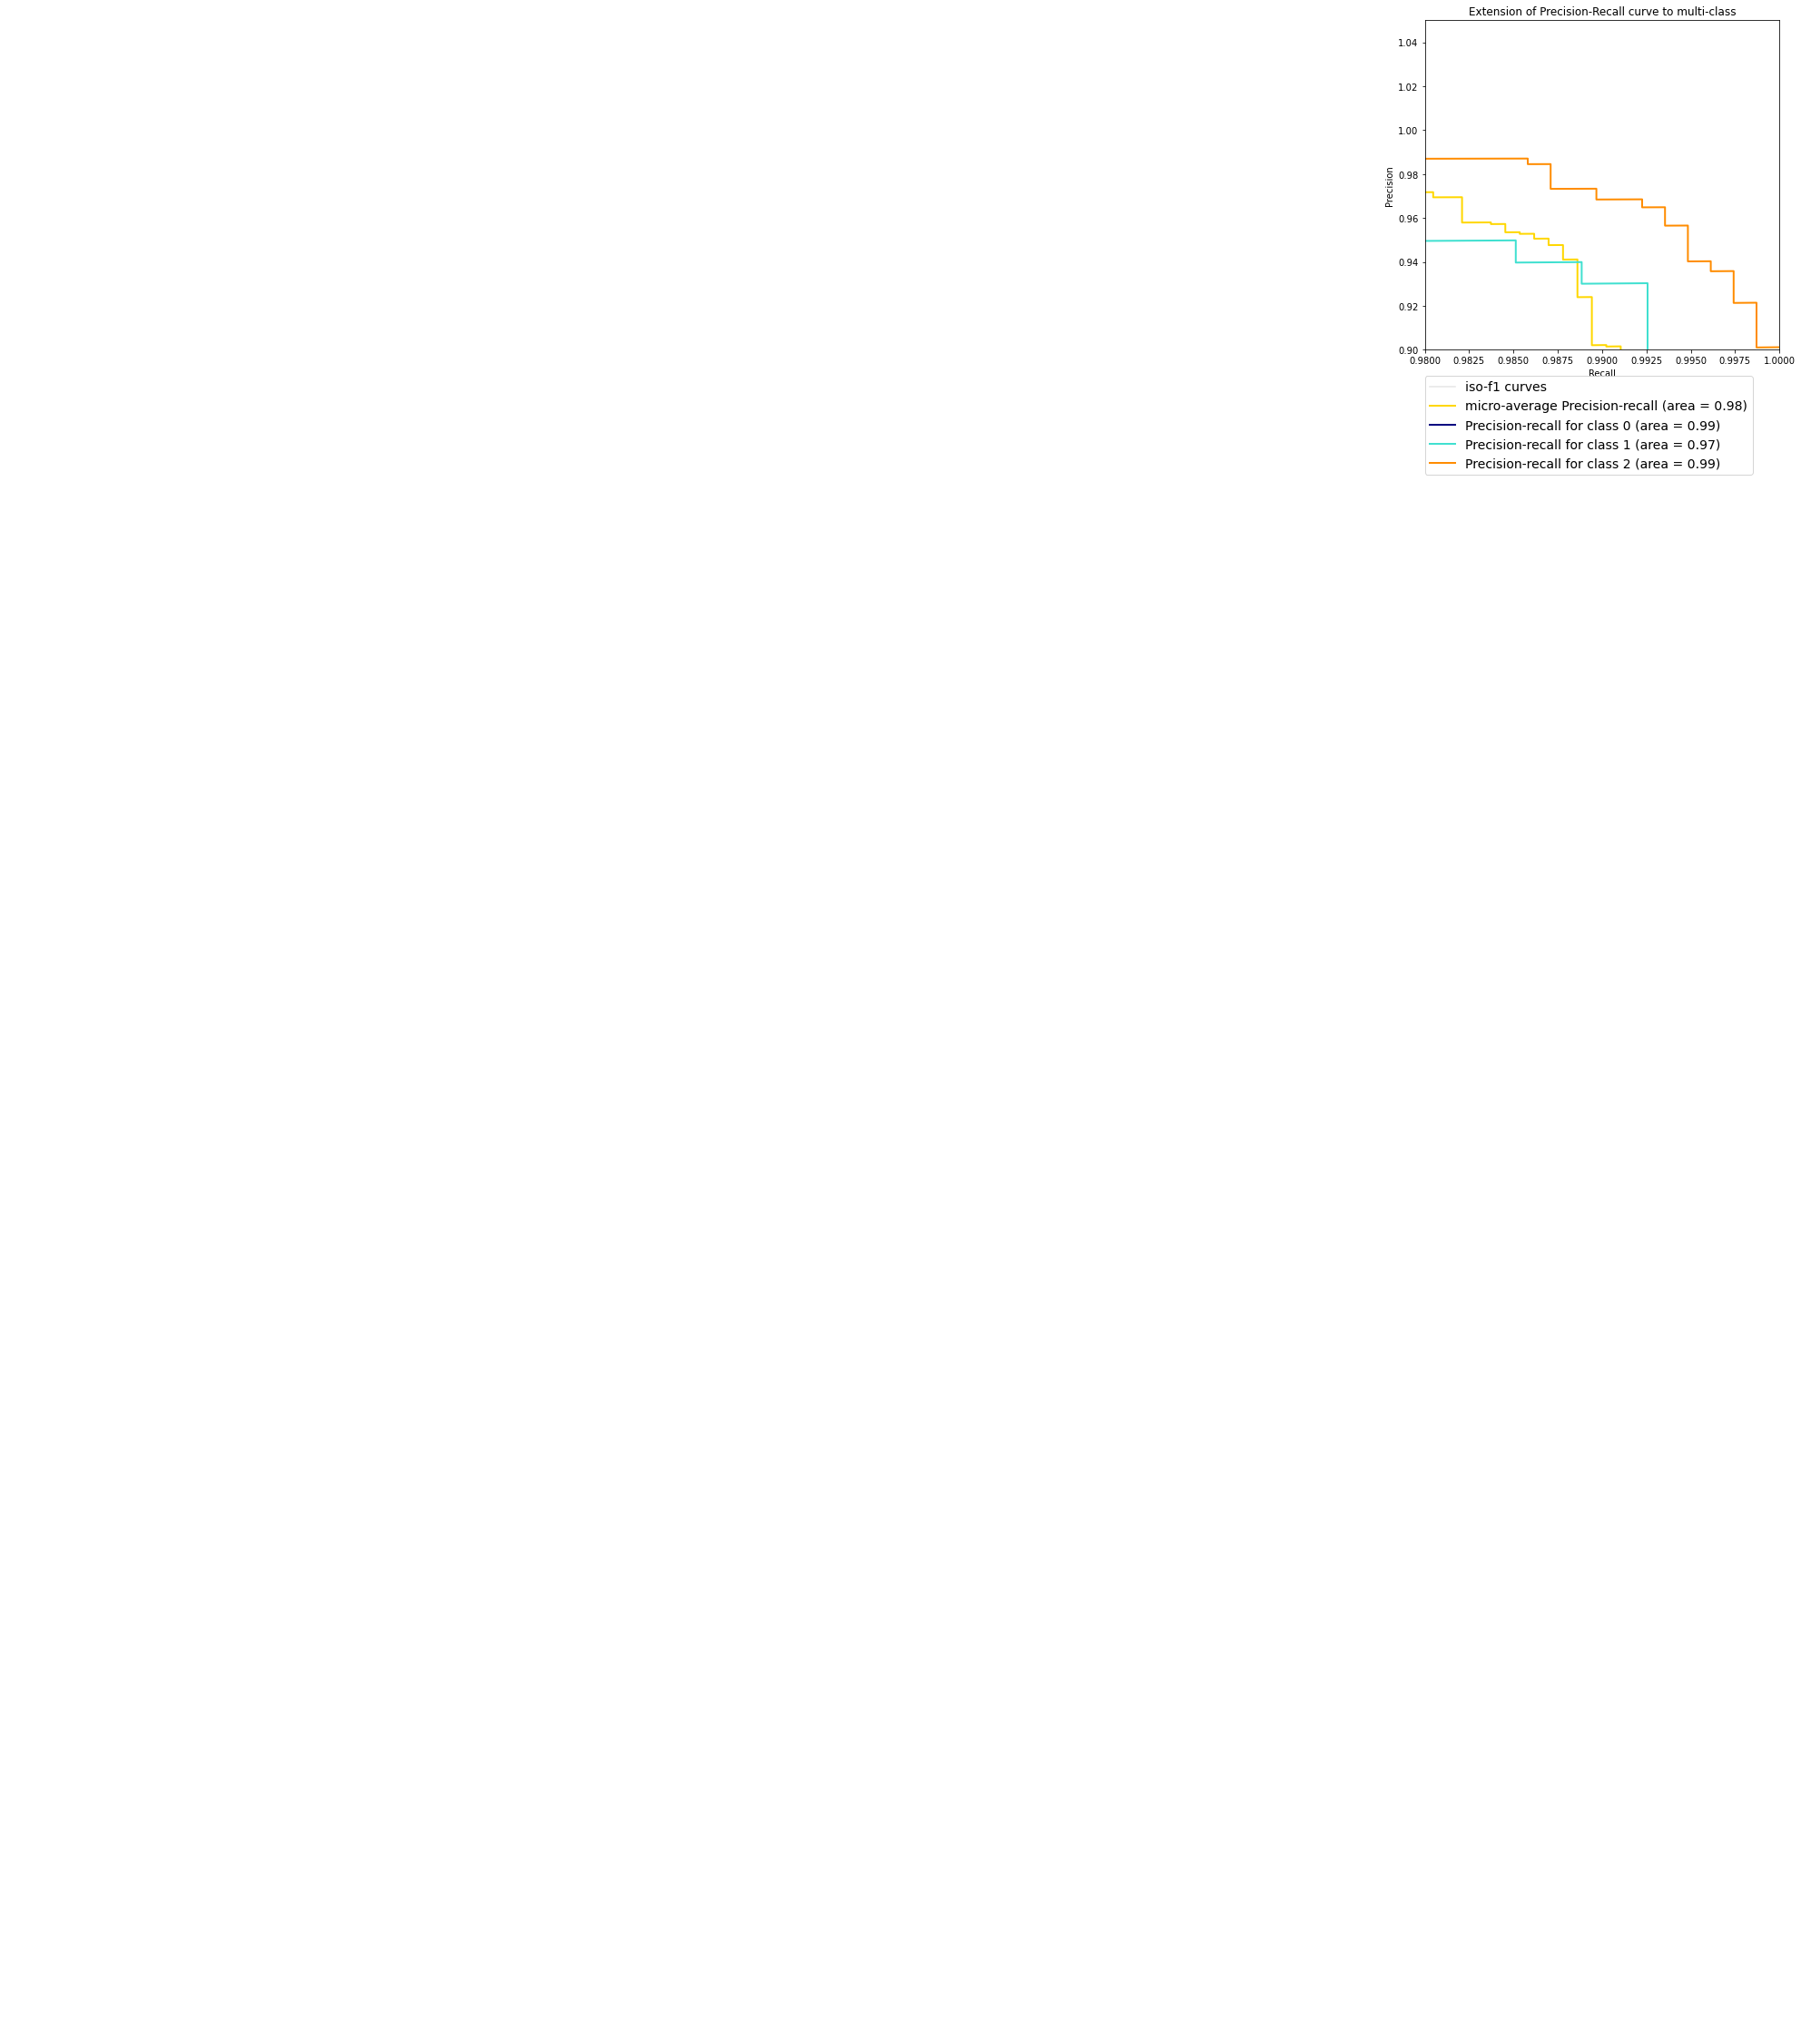

In [50]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(3), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.98, 1.0])
plt.ylim([0.9, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

fig.savefig('mobilenet_curve.png', dpi=400)
plt.show()

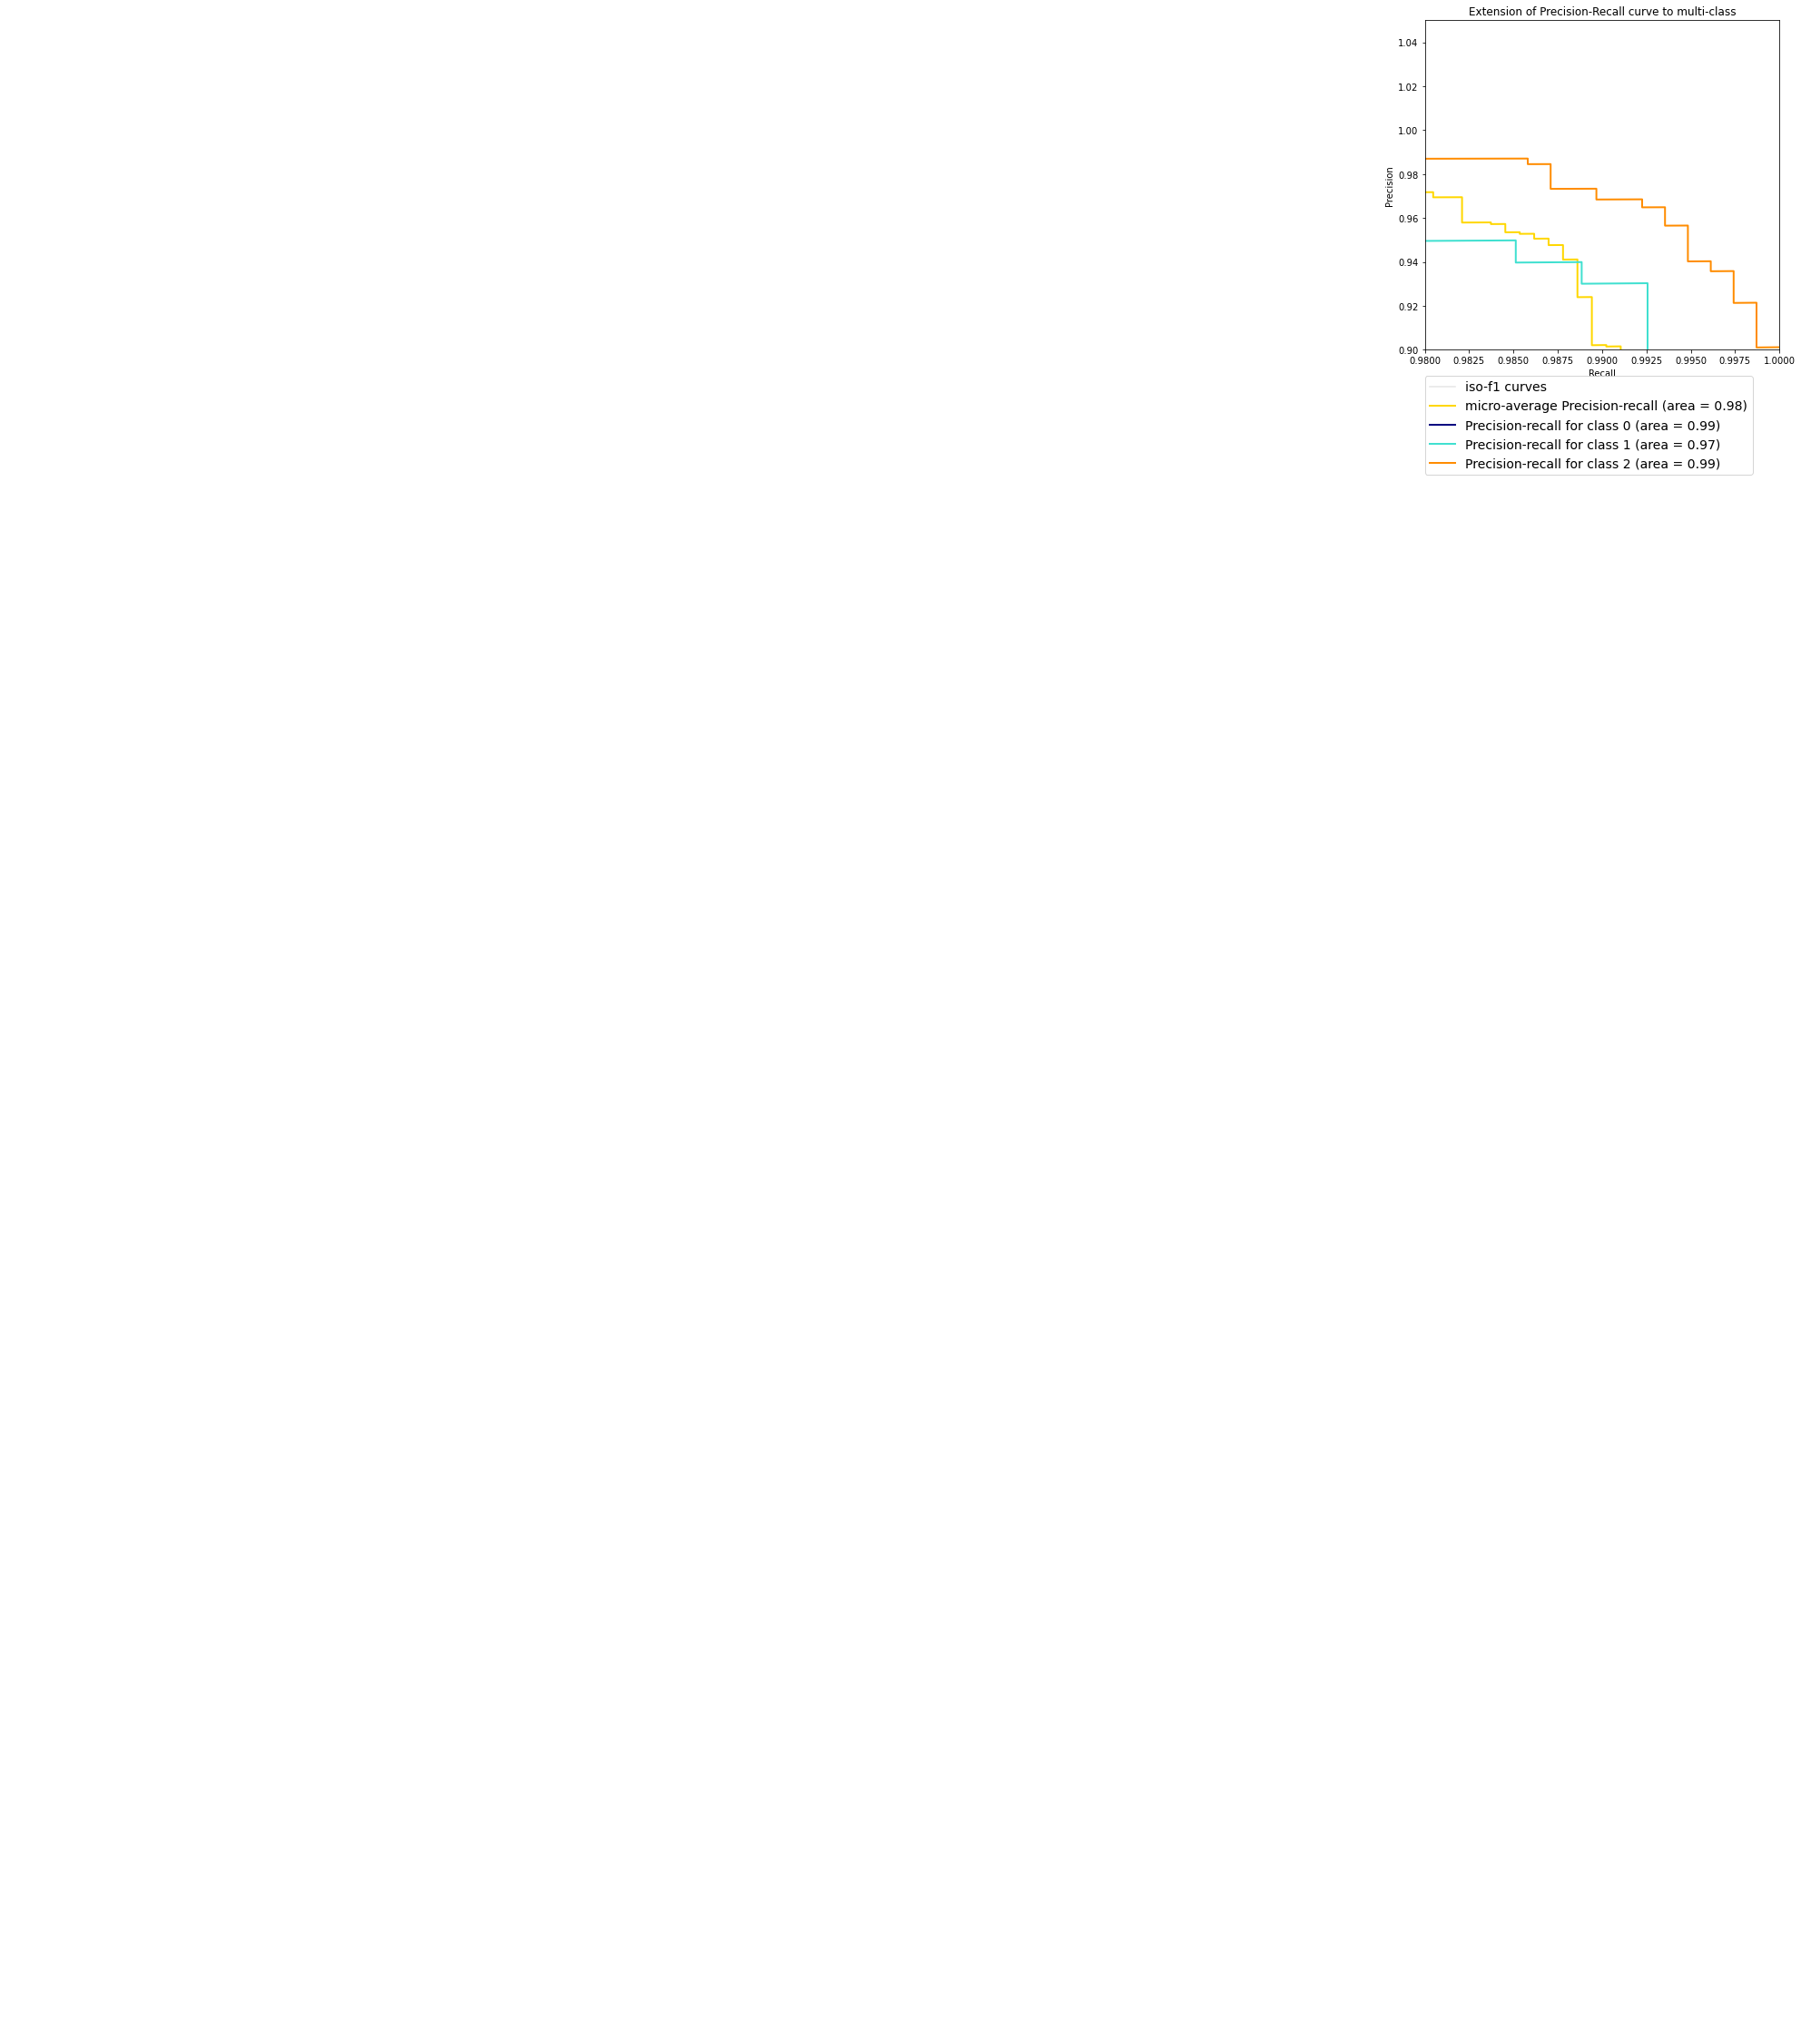

In [51]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(3), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.98, 1.0])
plt.ylim([0.9, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

fig.savefig('vgg_curve.png', dpi=400)
plt.show()

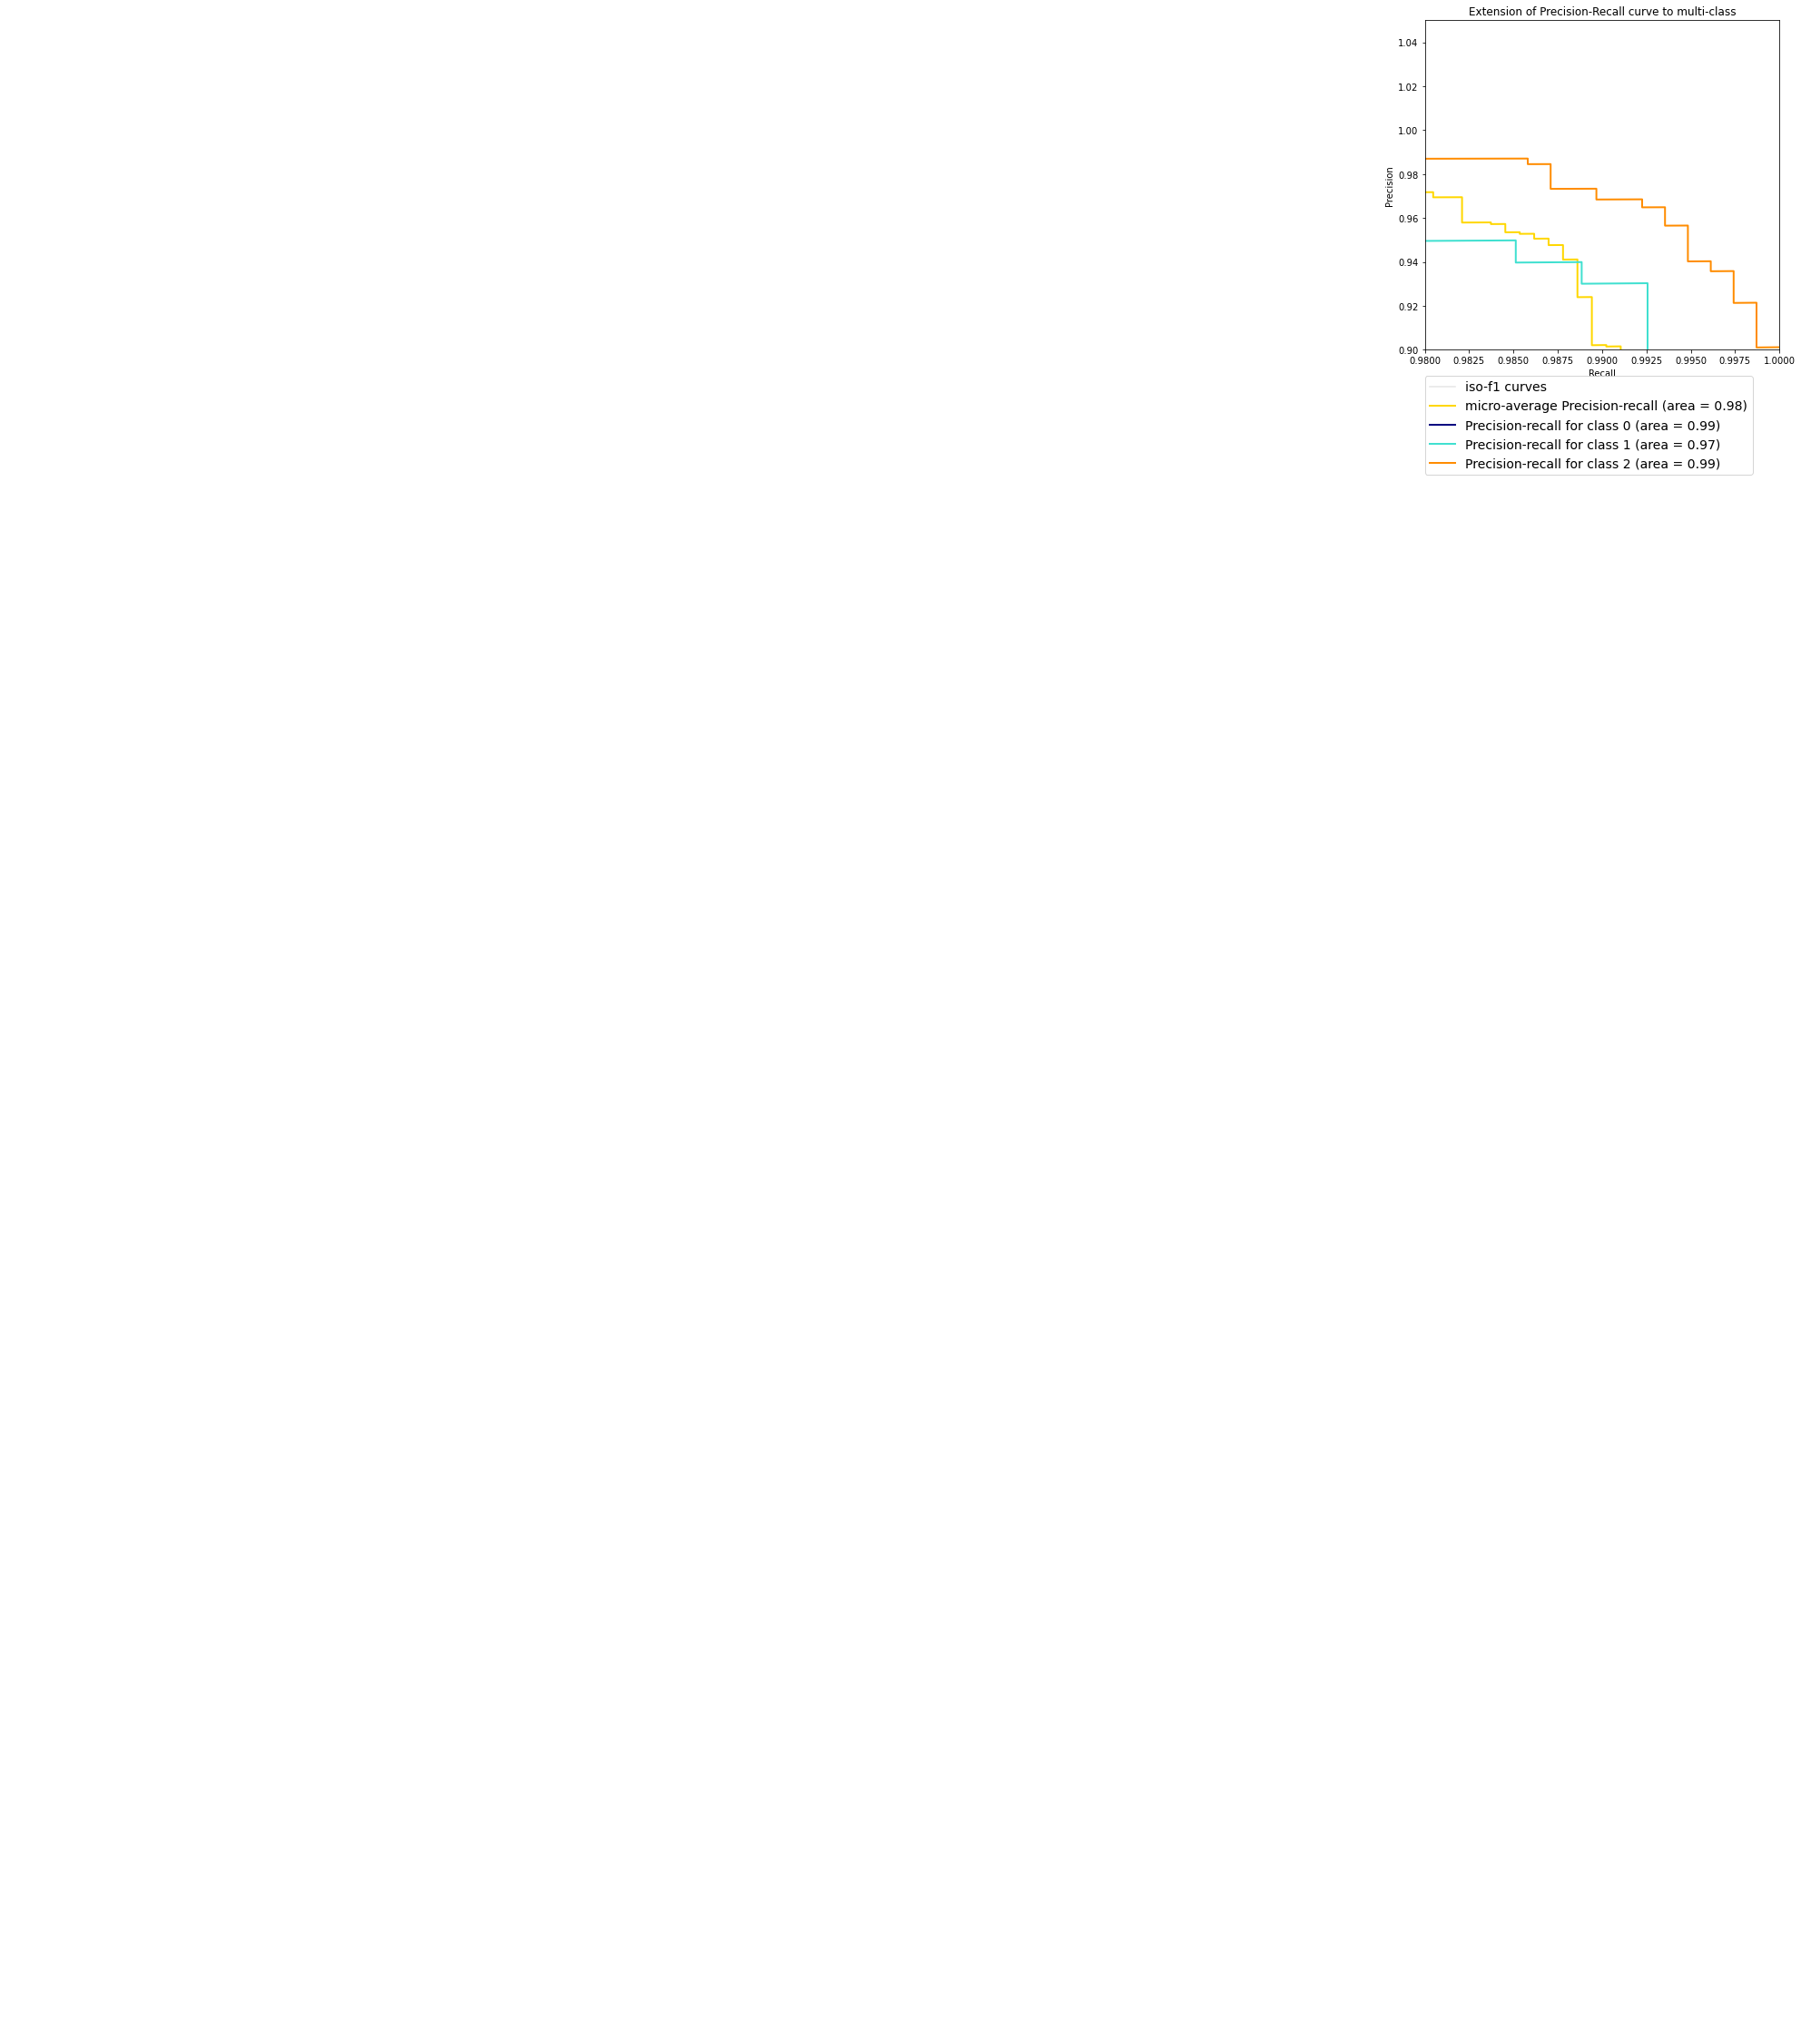

In [52]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(3), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.98, 1.0])
plt.ylim([0.9, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

fig.savefig('inception_curve.png', dpi=400)
plt.show()

In [53]:
vgg.save("VGG.h5")
inception.save("inception.h5")
mobilenet.save("mobilenet.h5")

In [54]:
from sympy.solvers import solve
from sympy import Symbol
fuzzymeasures = np.array([0.09,0.08,0.07])
l = Symbol('l', real = True)
lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) - (l+1), l )
lam = lam[1]
Ypred_fuzzy = np.zeros(shape = inception_test.shape, dtype = float)

In [55]:

for sample in range(0,inception_test.shape[0]):
    for classes in range(0,3):
        scores = np.array([mobilenet_test[sample][classes],inception_test[sample][classes],vgg_test[sample][classes]])
        #print(scores.shape)
        permutedidx = np.flip(np.argsort(scores))
        #print(permutedidx.shape)
        scoreslambda = scores[permutedidx]
        #print(scoreslambda.shape)
        fmlambda = fuzzymeasures[permutedidx]

        ge_prev = fmlambda[0]
        fuzzyprediction = scoreslambda[0] * fmlambda[0]

        for i in range(1,2):
            ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
            fuzzyprediction = fuzzyprediction + scoreslambda[i] *(ge_curr - ge_prev)
            ge_prev = ge_curr

        fuzzyprediction = fuzzyprediction + scoreslambda[2] * ( 1 - ge_prev)
        Ypred_fuzzy[sample][classes] = fuzzyprediction
ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)

In [56]:

pred_label = []
for i in ypred_fuzzy:
    label = np.zeros((3))
    label[i] = label[i]+1
    pred_label.append(label)
pred_label = np.array(pred_label)

In [57]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(classification_report(test_labels,pred_label))
print(accuracy_score(test_labels,pred_label))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       185
           1       0.99      1.00      0.99       269
           2       1.00      1.00      1.00       775

   micro avg       0.99      0.99      0.99      1229
   macro avg       0.99      0.99      0.99      1229
weighted avg       0.99      0.99      0.99      1229
 samples avg       0.99      0.99      0.99      1229

0.9943043124491456
